# ML4MSD - Homework 4: Assignment 1
# Exercise 11.1 - Full ML Pipeline

**Author**: Ardavan Mehdizadeh  
**Date**: Oct 20, 2025  
**Dataset**: matbench_jdft2d (Exfoliation Energy)

## Dataset Selection

I chose **matbench_jdft2d** because exfoliation energy relates to my research on surface energy and cleavage energy prediction. Now for this case, since I am focusing on predicting interlayer bonding strength in 2D materials, I selected ElementProperty (Magpie) for comprehensive elemental statistics and EwaldSumMatrix to capture long-range electrostatic interactions between layers.

## Featurization Approaches

1. **Compositional**: ElementProperty (Magpie preset)
2. **Structural**: EwaldSumMatrix

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matminer.datasets import load_dataset
from matminer.featurizers.composition.composite import ElementProperty
from dscribe.descriptors import EwaldSumMatrix
from pymatgen.io.ase import AseAtomsAdaptor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load dataset
print("Loading matbench_jdft2d dataset...")
df = load_dataset('matbench_jdft2d')
print(f"✓ Dataset loaded: {len(df)} samples")
print(f"✓ Target: exfoliation_en (meV/atom)")
print("\nTarget statistics:")
print(df['exfoliation_en'].describe())

/Users/mehdizadeh.a/Library/CloudStorage/OneDrive-NortheasternUniversity/ML4MSD-HW-Ardavan/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading matbench_jdft2d dataset...
Fetching matbench_jdft2d.json.gz from https://ml.materialsproject.org/projects/matbench_jdft2d.json.gz to /Users/mehdizadeh.a/Library/CloudStorage/OneDrive-NortheasternUniversity/ML4MSD-HW-Ardavan/.venv/lib/python3.11/site-packages/matminer/datasets/matbench_jdft2d.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_jdft2d.json.gz in MB: 0.26828799999999997MB [00:00, 90.49MB/s]      

✓ Dataset loaded: 636 samples
✓ Target: exfoliation_en (meV/atom)

Target statistics:
count     636.000000
mean      112.698309
std       134.276663
min         0.026500
25%        58.811481
50%        79.803667
75%       101.289264
max      1604.038286
Name: exfoliation_en, dtype: float64


## 1. Compositional Featurization (ElementProperty - Magpie)

In [4]:
# Extract compositions
df_comp = df.copy()
df_comp['composition'] = df_comp['structure'].apply(lambda x: x.composition)
print("✓ Compositions extracted")

# Featurize with ElementProperty
el_prop = ElementProperty.from_preset(preset_name='magpie', impute_nan=False)
el_prop.set_n_jobs(1)
df_feat1 = el_prop.featurize_dataframe(df_comp, col_id='composition')
print(f"✓ Generated {df_feat1.shape[1]-3} features")

/Users/mehdizadeh.a/Library/CloudStorage/OneDrive-NortheasternUniversity/ML4MSD-HW-Ardavan/.venv/lib/python3.11/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


✓ Compositions extracted


ElementProperty: 100%|██████████| 636/636 [00:00<00:00, 1261.53it/s]

✓ Generated 132 features


In [5]:
# Prepare target and features
y = df_feat1['exfoliation_en']
X_all = df_feat1.drop(columns=['exfoliation_en', 'structure', 'composition'])

print(f"Initial features: {X_all.shape[1]}")

# Remove low variance features
X_all = X_all.loc[:, X_all.var() > 1e-5]
print(f"After removing low variance: {X_all.shape[1]}")

# Remove highly correlated features
corr_matrix = X_all.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.99)]
X_comp = X_all.drop(columns=to_drop)

print(f"✓ Final compositional features: {X_comp.shape[1]}")

Initial features: 132
After removing low variance: 126
✓ Final compositional features: 112


In [6]:
# Scale features
scaler_comp = StandardScaler()
X_scaled = scaler_comp.fit_transform(X_comp)

# Split data
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_scaled, y, test_size=0.1, random_state=17
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2/(1-0.1), random_state=17
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Val:   {X_val.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")

# Baseline
baseline_mae = mean_absolute_error(y_val, [y_train.mean()] * len(y_val))
print(f"\n✓ Baseline MAE: {baseline_mae:.4f} meV/atom")

Train: 444 samples
Val:   128 samples
Test:  64 samples

✓ Baseline MAE: 57.9636 meV/atom


In [7]:
# Train Random Forest
print("Training compositional model...")
rf_comp = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=-1)
rf_comp.fit(X_train, y_train)

# Evaluate on test set
y_test_pred_comp = rf_comp.predict(X_test)
mae_test_comp = mean_absolute_error(y_test, y_test_pred_comp)
r2_test_comp = r2_score(y_test, y_test_pred_comp)

print(f"\n✓ Compositional Results:")
print(f"   Test MAE: {mae_test_comp:.4f} meV/atom")
print(f"   Test R²:  {r2_test_comp:.4f}")

Training compositional model...

✓ Compositional Results:
   Test MAE: 46.8878 meV/atom
   Test R²:  0.6629


## 2. Structural Featurization (EwaldSumMatrix)

In [8]:
# Setup EwaldSumMatrix
n_max = max(len(s) for s in df['structure'])
print(f"Maximum atoms in structures: {n_max}")

ews = EwaldSumMatrix(n_atoms_max=n_max, permutation="eigenspectrum")
print("✓ EwaldSumMatrix initialized")

# Featurize
print("Featurizing structures...")
ase_structures = [AseAtomsAdaptor.get_atoms(s) for s in df['structure']]
ews_features = ews.create(ase_structures)
print(f"✓ Generated {ews_features.shape[1]} EwaldSumMatrix features")

Maximum atoms in structures: 35
✓ EwaldSumMatrix initialized
Featurizing structures...
✓ Generated 35 EwaldSumMatrix features


In [9]:
# Clean features
X_ews = pd.DataFrame(ews_features)
print(f"Initial features: {X_ews.shape[1]}")

X_ews = X_ews.loc[:, X_ews.var() > 1e-5]
print(f"After removing low variance: {X_ews.shape[1]}")

corr_matrix = X_ews.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.99)]
X_ews = X_ews.drop(columns=to_drop)

print(f"✓ Final EwaldSumMatrix features: {X_ews.shape[1]}")

Initial features: 35
After removing low variance: 35
✓ Final EwaldSumMatrix features: 24


In [10]:
# Scale and split
scaler_ews = StandardScaler()
X_ews_scaled = scaler_ews.fit_transform(X_ews)

X_trainval_e, X_test_e, _, _ = train_test_split(
    X_ews_scaled, y, test_size=0.1, random_state=17
)
X_train_e, X_val_e, _, _ = train_test_split(
    X_trainval_e, y_trainval, test_size=0.2/(1-0.1), random_state=17
)

# Train model
print("Training structural model...")
rf_ews = RandomForestRegressor(n_estimators=200, random_state=17, n_jobs=-1)
rf_ews.fit(X_train_e, y_train)

# Evaluate
y_test_pred_ews = rf_ews.predict(X_test_e)
mae_test_ews = mean_absolute_error(y_test, y_test_pred_ews)
r2_test_ews = r2_score(y_test, y_test_pred_ews)

print(f"\n✓ EwaldSumMatrix Results:")
print(f"   Test MAE: {mae_test_ews:.4f} meV/atom")
print(f"   Test R²:  {r2_test_ews:.4f}")

Training structural model...

✓ EwaldSumMatrix Results:
   Test MAE: 66.2257 meV/atom
   Test R²:  0.4553


## 3. Results Summary

In [11]:
print("="*60)
print("GOOGLE SHEET SUBMISSION DATA")
print("="*60)
print(f"Matminer Dataset: matbench_jdft2d")
print(f"Featurization 1: ElementProperty (magpie)")
print(f"Featurization 2: EwaldSumMatrix")
print(f"Scikit-Learn Model: RandomForestRegressor")
print(f"Mean Baseline MAE: {baseline_mae:.4f}")
print(f"test-MAE (featurizer1): {mae_test_comp:.4f}")
print(f"test-R² (featurizer1): {r2_test_comp:.4f}")
print(f"test-MAE (featurizer2): {mae_test_ews:.4f}")
print(f"test-R² (featurizer2): {r2_test_ews:.4f}")
print("="*60)

GOOGLE SHEET SUBMISSION DATA
Matminer Dataset: matbench_jdft2d
Featurization 1: ElementProperty (magpie)
Featurization 2: EwaldSumMatrix
Scikit-Learn Model: RandomForestRegressor
Mean Baseline MAE: 57.9636
test-MAE (featurizer1): 46.8878
test-R² (featurizer1): 0.6629
test-MAE (featurizer2): 66.2257
test-R² (featurizer2): 0.4553


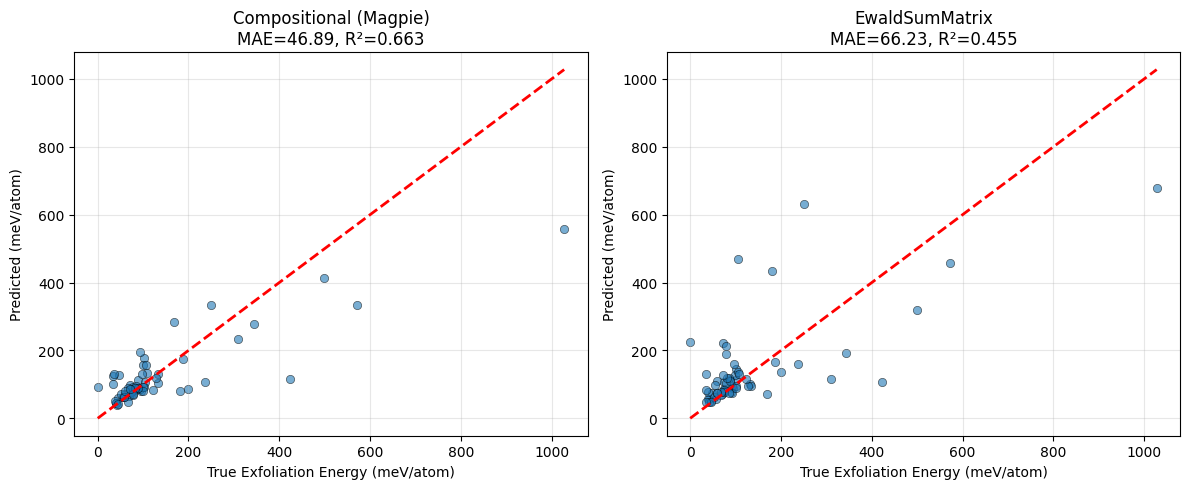

✅ Assignment complete! Results saved to hw4_results.png


In [12]:
# Create parity plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Compositional
axes[0].scatter(y_test, y_test_pred_comp, alpha=0.6, edgecolors='black', linewidths=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('True Exfoliation Energy (meV/atom)')
axes[0].set_ylabel('Predicted (meV/atom)')
axes[0].set_title(f'Compositional (Magpie)\nMAE={mae_test_comp:.2f}, R²={r2_test_comp:.3f}')
axes[0].grid(alpha=0.3)

# Structural
axes[1].scatter(y_test, y_test_pred_ews, alpha=0.6, edgecolors='black', linewidths=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('True Exfoliation Energy (meV/atom)')
axes[1].set_ylabel('Predicted (meV/atom)')
axes[1].set_title(f'EwaldSumMatrix\nMAE={mae_test_ews:.2f}, R²={r2_test_ews:.3f}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('hw4_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Assignment complete! Results saved to hw4_results.png")